# Reinforcement Learning: Individual Assignement
## Timothée RIO

In [1]:
import os, sys
import gym
import time
import jdc
import numpy as np
import text_flappy_bird_gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

c:\Users\33631\Documents\Etudes\centrale 3A\RL\flappy_bird_assignement\venv\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\33631\Documents\Etudes\centrale 3A\RL\flappy_bird_assignement\venv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


# Usefull Stuff

In [27]:
def moving_average(input_list, size = 1000):
    input_list = np.array(input_list)
    moving_means = []
    n = len(input_list)
    for i in range(size,n, size):
        mean = np.mean(input_list[max(0,i-size):i])
        moving_means.append(mean)
    return(moving_means)

In [64]:
def plot_state_value(q_dict):
    def f(x, y):
        if (x,y) in q_dict.keys():
            return max(q_dict[(x,y)])
        else:
            return(0)

    X, Y = np.meshgrid(x_coords,y_coords)
    Z = np.array([f(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=plt.cm.coolwarm)
    ax.set_xlabel('Horizontal Distance to pipe')
    ax.set_ylabel('Vertical Distance to pipe')
    ax.set_zlabel('State Value')

# First Agent: Q-learning agent

In [40]:
class QLearningAgent():
    def agent_init(self, agent_init_info):
        self.num_actions = agent_init_info["num_actions"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])

        self.q = {}

        
    def agent_start(self, state):

        current_q = self.q.setdefault(state,[0,0])
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        # Choose action using epsilon greedy.
        current_q = self.q.setdefault(state,[0,0])
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        previous_values_list = self.q[self.prev_state]
        previous_values_list[self.prev_action] += self.step_size*(reward + self.discount*np.max(self.q[state]) - self.q[self.prev_state][self.prev_action])
        self.q[self.prev_state] = previous_values_list
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        previous_values_list = self.q[self.prev_state]
        previous_values_list[self.prev_action] += self.step_size*(reward - self.q[self.prev_state][self.prev_action])
        self.q[self.prev_state] = previous_values_list

        
    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

    def set_epsilon(self, value):
        self.epsilon = value

    @staticmethod
    def load(path):
        obj = pickle.load(open(path,'wb'))
        return(obj)

## Second Agent: Expected SARSA agent

In [41]:
class SarsaAgent():
    def agent_init(self, agent_init_info):
        self.num_actions = agent_init_info["num_actions"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        self.q = {}

        
    def agent_start(self, state):
        current_q = self.q.setdefault(state,[0,0])
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        # Choose action using epsilon greedy.
        current_q = self.q.setdefault(state,[0,0])
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        best_q = np.max(current_q)
        number_of_greedy_actions = np.sum(current_q==best_q)
        proba_non_greedy = (self.epsilon / self.num_actions)
        proba_greedy = ((1 - self.epsilon) / number_of_greedy_actions) + (self.epsilon / self.num_actions)
        expected_q = 0 
        for a in range(self.num_actions):
            if current_q[a] != best_q: 
                expected_q += current_q[a] * proba_non_greedy 
            else: 
                expected_q += current_q[a] * proba_greedy
        
        previous_values_list = self.q[self.prev_state]
        previous_values_list[self.prev_action] += self.step_size*(reward + self.discount*expected_q - self.q[self.prev_state][self.prev_action])
        self.q[self.prev_state] = previous_values_list

        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        previous_values_list = self.q[self.prev_state]
        previous_values_list[self.prev_action] += self.step_size*(reward - self.q[self.prev_state][self.prev_action])
        self.q[self.prev_state,self.prev_action] = previous_values_list
    
        
    def argmax(self, q_values):
        top = float("-inf")
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []
            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

    def set_epsilon(self, value):
        self.epsilon = value


    @staticmethod
    def load(path):
        obj = pickle.load(open(path,'rb'))
        return(obj)

## Experiments and Plots

### Simulations

In [100]:
###### main parameters
number_of_episodes = 20000
epsilon_value = 0.1
epsilon_decay = 0.9 # every 5000 episodes
agent_info = {"num_actions": 2 , "epsilon": epsilon_value, "step_size": 0.1, "discount": 1.0, "seed": 0}

##### initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

##### initialise both agents
q_learning_agent = QLearningAgent()
sarsa_agent = SarsaAgent()
agents_dict = {'q_learning': q_learning_agent, 'sarsa': sarsa_agent}


for agent_name in agents_dict.keys():
    agents_dict[agent_name].agent_init(agent_info)

#### play episode
rewards = {}
for name, agent in agents_dict.items():
    print(f"start training {name}")
    rewards_dict = {}
    epsilon_value = 0.1
    agent.set_epsilon(epsilon_value)
    for episode in tqdm(range(number_of_episodes), position = 0):
        current_reward = 0
        obs = env.reset()
        action = agent.agent_start(obs)
        ## decrease epsilon :
        if episode % 5000 == 0:
            epsilon_value = epsilon_value*epsilon_decay
            agent.set_epsilon(epsilon_value)

        while True:
            obs, reward, done, info = env.step(action)
            current_reward += reward
            if done:
                agent.agent_end(reward)
                rewards_dict[episode] = current_reward # if episodes terminates, save the obtained reward
                break
            else:
                action = agent.agent_step(reward, obs)

    #### save agents for latter use
    rewards[name] = rewards_dict
    pickle.dump(agent,open(f"{name}.pkl","wb"))

start training q_learning


100%|██████████| 20000/20000 [01:55<00:00, 173.57it/s]


start training sarsa


100%|██████████| 20000/20000 [02:58<00:00, 111.94it/s]


## Plots

### Compare rewards

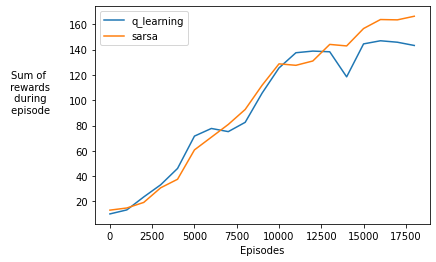

In [105]:
size = 1000
for name in rewards.keys():
    rewards_list = list(rewards[name].values())
    moving_means = moving_average(rewards_list, size = size)
    plt.plot([size*episode for episode in range(0,len(moving_means))],moving_means, label=name)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.legend()
plt.show()

## Compare state value fonctions

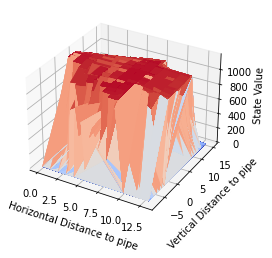

In [106]:
plot_state_value(agents_dict['q_learning'].q)

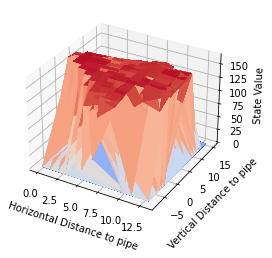

In [107]:
plot_state_value(agents_dict['sarsa'].q)

### Parameters sweep graphs

Compare step sizes effects

In [108]:
###### main parameters
number_of_episodes = 10000
step_size_list = [0.1*i for i in range(1,11)]
epsilon_decay = 0.9 # every 5000 episodes
epsilon_value = 0.1
##### initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
rewards_steps_size_dict = {}
for step_size in step_size_list:
    print(f"let\'s train with step size: {step_size}")
    ##### initialise both agents
    q_learning_agent = QLearningAgent()
    sarsa_agent = SarsaAgent()
    agents_dict = {'q_learning': q_learning_agent, 'sarsa': sarsa_agent}

    agent_info = {"num_actions": 2 , "epsilon": 0.1, "step_size":step_size , "discount": 1.0, "seed": 0}
    for agent_name in agents_dict.keys():
        agents_dict[agent_name].agent_init(agent_info)

    #### play episode
    rewards_steps_size_agent = {}
    for name, agent in agents_dict.items():        
        rewards_list = []
        epsilon_value = 0.1
        agent.set_epsilon(epsilon_value)
        for episode in tqdm(range(number_of_episodes), position = 0):
            current_reward = 0
            obs = env.reset()
            action = agent.agent_start(obs)
            ## decrease epsilon :
            if episode % 5000 == 0:
                epsilon_value = epsilon_value*epsilon_decay
                agent.set_epsilon(epsilon_value)

            while True:
                obs, reward, done, info = env.step(action)
                current_reward += reward
                if done:
                    agent.agent_end(reward)
                    rewards_list.append(current_reward) # if episodes terminates, save the obtained reward
                    break
                else:
                    action = agent.agent_step(reward, obs)
        rewards_steps_size_agent[name] = np.sum(rewards_list)/len(rewards_list)
    rewards_steps_size_dict[step_size] = rewards_steps_size_agent

let's train with step size: 0.1


100%|██████████| 10000/10000 [00:30<00:00, 326.96it/s]


let's train with step size: 0.2


100%|██████████| 10000/10000 [01:32<00:00, 108.38it/s]


let's train with step size: 0.30000000000000004


100%|██████████| 10000/10000 [01:08<00:00, 146.31it/s]


let's train with step size: 0.4


100%|██████████| 10000/10000 [01:15<00:00, 131.82it/s]


let's train with step size: 0.5


100%|██████████| 10000/10000 [01:54<00:00, 87.37it/s]


let's train with step size: 0.6000000000000001


100%|██████████| 10000/10000 [01:21<00:00, 123.03it/s]


let's train with step size: 0.7000000000000001


100%|██████████| 10000/10000 [01:14<00:00, 134.60it/s]


let's train with step size: 0.8


100%|██████████| 10000/10000 [01:08<00:00, 145.93it/s]


let's train with step size: 0.9


100%|██████████| 10000/10000 [00:54<00:00, 183.35it/s]


let's train with step size: 1.0


100%|██████████| 10000/10000 [00:55<00:00, 179.30it/s]


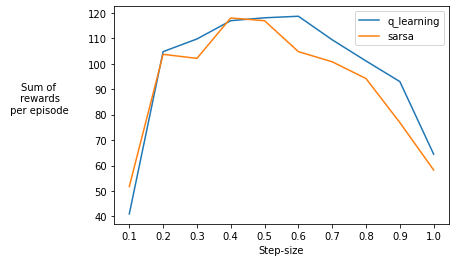

In [109]:
for model in ["q_learning", "sarsa"]:
    values = []
    for step in rewards_steps_size_dict.keys():
        values.append(rewards_steps_size_dict[step][model])
    plt.plot(rewards_steps_size_dict.keys(), values, label = model)
    
plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(list(rewards_steps_size_dict.keys()))
plt.show()

## Third agent (bonus): Deep Q learning Agent

In [119]:
class NN(nn.Module):
    def __init__(self, input_shape = 2, n_actions = 2):
        super(NN, self).__init__()

        self.conv_net  = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 12, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2)),
            nn.Flatten()
        )
            
        self.dense = nn.Sequential(
            nn.Linear(12*30*7, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100,  n_actions)
        )

    def forward(self, x):
        x = self.conv_net(x)
        o = self.dense(x)
        return o

In [128]:
class DQNAgent:

    def agent_init(self, agent_init_info, batch_size = 8, max_memory_size = 100000):

        # Store the parameters provided in agent_init_info.
        self.state_shape = agent_init_info["states_shape"]
        self.num_actions = agent_init_info["num_actions"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.state_space = 2
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # DQN network  
        self.dqn = NN(2, self.num_actions).to(self.device)
        self.target_network = NN(2, self.num_actions).to(self.device)
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=self.step_size)

        # Create memory
        self.max_memory_size = max_memory_size

        self.STATE_MEM = torch.zeros(max_memory_size, *self.state_shape)
        self.ACTION_MEM = torch.zeros(max_memory_size, 1)
        self.REWARD_MEM = torch.zeros(max_memory_size, 1)
        self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_shape)
        self.DONE_MEM = torch.zeros(max_memory_size, 1)
        self.ending_position = 0
        self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss


    def remember(self, state, action, reward, state2, done):
        """Store the experiences in a buffer to use later"""
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) #% self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
    
    def batch_experiences(self):
        """Randomly sample 'batch size' experiences"""
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]      
        return STATE, ACTION, REWARD, STATE2, DONE
    
    def step(self, state):
        """Epsilon-greedy action"""
        if random.random() < self.epsilon:  
            return torch.tensor([[random.randrange(self.num_actions)]])
        else:
            state = torch.unsqueeze(state, dim = 0)
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    def update_target_network(self):
        self.target_network.load_state_dict(self.dqn.state_dict())
        self.target_network.eval()

    def experience_replay(self):
        if self.memory_sample_size > self.num_in_queue:
            return
        # Sample a batch of experiences
        STATE, ACTION, REWARD, STATE2, DONE = self.batch_experiences()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
        with torch.no_grad():
            target = REWARD + torch.mul((self.discount * self.target_network(STATE2).max(1).values.unsqueeze(1)), 1 - DONE)
        current = self.dqn(STATE).gather(1, ACTION.long())
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error
        
    def set_epsilon(self, value):
        self.epsilon = value

    @staticmethod
    def load(path):
        obj = pickle.load(open(path,'wb'))
        return(obj)

In [126]:
def pre_processed(obs):
    obs = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)
    obs = cv2.resize(obs, ((64,18)))
    return(obs)

## Simulations deep q learning

In [129]:
import flappy_bird_gym
number_of_episodes = 5000
rewards_dict = {}
# initiate environment
env = flappy_bird_gym.make("FlappyBird-rgb-v0")
# initialise agent
epsilon_value = 1
agent_info = {"states_shape":[1, 18, 64],"num_actions": 2 , "epsilon": epsilon_value, "step_size": 0.1, "discount": 1.0, "seed": 0}

agent = DQNAgent()
agent.agent_init(agent_info)
   
for episode in tqdm(range(number_of_episodes), position = 0):
    if episode == 20:
        epsilon_value  = 0.2
        agent.set_epsilon(epsilon_value)
        
    if episode > 20 and episode%500:
        epsilon_value  = epsilon_value*0.9
        agent.set_epsilon(epsilon_value)

    if episode % 10 == 0 and episode>=20:
        agent.update_target_network()

    current_reward = 0
    state = env.reset()
    state = pre_processed(state)
    state = torch.Tensor([state])
    while True:
        action = agent.step(state)
        # action
        state_next, reward, done, info = env.step(int(action[0][0]))
        state_next = pre_processed(state_next)
        current_reward += reward

        # process output
        state_next = torch.Tensor([state_next])
        reward = torch.tensor([reward]).unsqueeze(0)
        done = torch.tensor([int(done)]).unsqueeze(0)

        # remember and train
        agent.remember(state, action, reward, state_next, done)
        if episode >= 20:
            agent.experience_replay()

        # update next state
        state = state_next
        if bool(done[0][0]):
            rewards_dict[episode] = current_reward
            if episode % 500 == 0:
                print(current_reward)
            break

  0%|          | 1/5000 [00:00<21:03,  3.96it/s]

101


  1%|▏         | 64/5000 [01:40<2:09:09,  1.57s/it]


KeyboardInterrupt: 

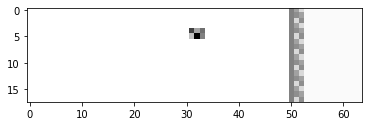

In [143]:
obs = env.reset()
obs = cv2.resize(obs,(64,18))
obs = pre_processed(obs)
plt.imshow(obs,cmap = "gray")

In [17]:
import time
import flappy_bird_gym
env = flappy_bird_gym.make("FlappyBird-rgb-v0")

obs = env.reset()
while True:
    # Next action:
    # (feed the observation to your agent here)
    action = ...  # env.action_space.sample() for a random action

    # Processing:
    obs, reward, done, info = env.step(action)
    print(obs.shape)
    print(env.render())
    # Rendering the game:
    # (remove this two lines during training)
    env.render()
    time.sleep(2)  # FPS
    
    # Checking if the player is still alive
    if done:
        break

env.close()

(288, 512, 3)
None


KeyboardInterrupt: 